# **Convolutional Neural Networks (CNNs) for MNIST Classification using PyTorch**  

Welcome to this practical session on Convolutional Neural Networks (CNNs)! In this notebook, we will implement a CNN using PyTorch to classify handwritten digits from the MNIST dataset.  

Before you begin, make sure to review the **slides in the provided folder**, which introduce the key concepts behind CNNs, including:  
- How convolutional layers work  
- The role of pooling layers  
- Activation functions and feature extraction  
- How CNNs improve performance in image classification tasks 

This is a cool link to visualize CNNs on the MNIST dataset: https://adamharley.com/nn_vis/cnn/3d.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

device = "cpu" # set to cuda if GPU or mps if MAC M1+
print(device)

cpu


In [2]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download MNIST
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [3]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # Images come in batches of 64. With a dimension of 28x28 pixels. 1 = Grayscale, 3 = Colour.
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


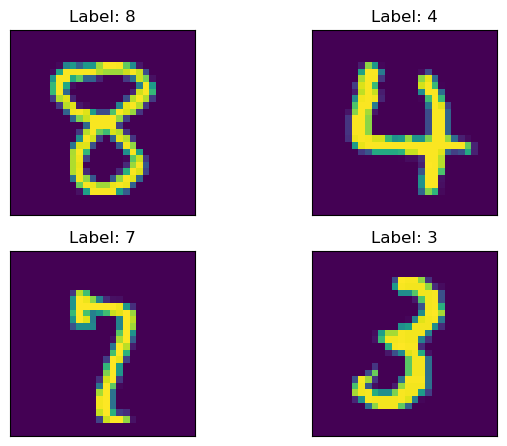

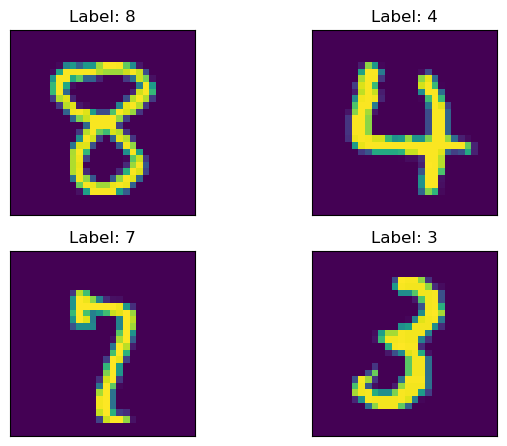

In [4]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0])
    plt.title("Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig
     

In [5]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Neural Network Layer 
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (64, 1, 28, 28) 
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size=2), # stride default value is kernel_size
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size=2) 
        )

        # Fully connected NN
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # 20% of Neurons randomly set to 0. Can you tell me why?
                nn.Linear(in_features=64, out_features=10) 
        )

    # execute the forwad pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1) # Turn into a 1D tensor
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1) # What is wrong with this line?
        return x
     

In [6]:
model = CNN()
model.to(device)
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()     

## Cross-Entropy Loss in PyTorch: And the common softmax bug


### Softmax Function
The **Softmax** function is often used in multi-class classification problems. It converts logits (raw predictions) into probabilities by exponentiating and normalising them across all classes. Mathematically, it is defined as:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$$

Where:
- $ z_i $ is the score or logit for the $ i $-th class.
- $ C $ is the total number of classes.
- The denominator is the sum of the exponentials of the logits for all classes.

### Cross Entropy Loss
**Cross Entropy Loss** is a loss function commonly used for classification tasks, especially with Softmax. It measures the dissimilarity between the true label distribution and the predicted distribution. The formula is:

$$
L = -\sum_{i=1}^{C} y_i \log(p_i)
$$

Where:
- $ y_i $ is the true probability distribution (usually one-hot encoded).
- $ p_i $ is the predicted probability for class \( i \) (the output of the Softmax function).
- $ C $ is the number of classes.

### How PyTorch Applies Softmax
In PyTorch, `torch.nn.CrossEntropyLoss()` combines the softmax activation and the cross-entropy loss function into one efficient operation. You do not need to manually apply `Softmax` before passing the logits to `CrossEntropyLoss`, as PyTorch applies it internally.

The `CrossEntropyLoss` in PyTorch expects raw logits as input (before softmax) and applies the softmax function internally during the loss calculation.

### To do:

Change the code to avoid explicitly using softmax and compare your results.

In [8]:
epochs = 10 # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # Model evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation.
        
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/10   Training loss: 0.9102   Testing loss: 0.2588   Test accuracy: 0.9255  
Epoch: 2/10   Training loss: 0.2868   Testing loss: 0.1703   Test accuracy: 0.9449  
Epoch: 3/10   Training loss: 0.2026   Testing loss: 0.1281   Test accuracy: 0.9602  
Epoch: 4/10   Training loss: 0.1557   Testing loss: 0.1078   Test accuracy: 0.9646  
Epoch: 5/10   Training loss: 0.1295   Testing loss: 0.0795   Test accuracy: 0.9745  
Epoch: 6/10   Training loss: 0.1130   Testing loss: 0.0759   Test accuracy: 0.9759  
Epoch: 7/10   Training loss: 0.0996   Testing loss: 0.0736   Test accuracy: 0.9765  
Epoch: 8/10   Training loss: 0.0912   Testing loss: 0.0591   Test accuracy: 0.9803  
Epoch: 9/10   Training loss: 0.0837   Testing loss: 0.0557   Test accuracy: 0.9802  
Epoch: 10/10   Training loss: 0.0769   Testing loss: 0.0519   Test accuracy: 0.9813  


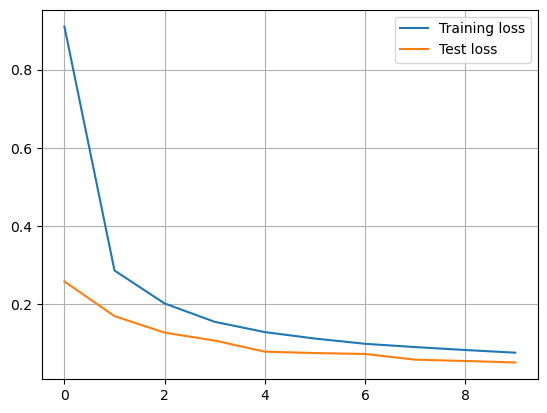

In [9]:
plt.plot([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses], label='Training loss')
plt.plot([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in test_losses], label='Test loss')
plt.legend()
plt.grid()

In [10]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[5.5315786e-07 9.9852186e-01 2.6582411e-06 5.5944433e-06 8.0110232e-04
 7.9762330e-08 4.7760557e-07 5.9201632e-04 5.6019471e-05 1.9510910e-05]


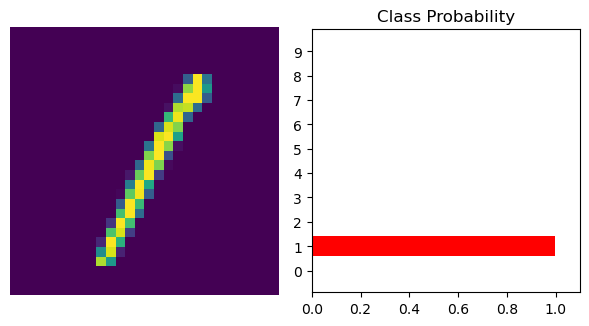

In [11]:
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

torch.Size([1, 1, 28, 28])


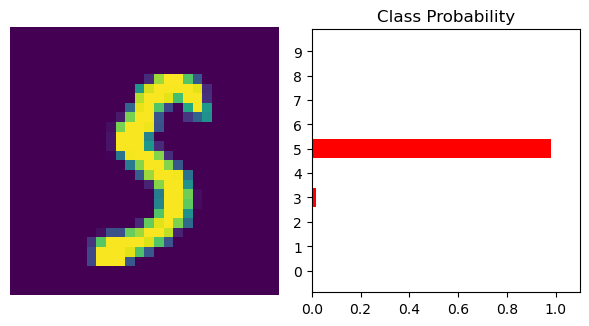

torch.Size([1, 1, 28, 28])


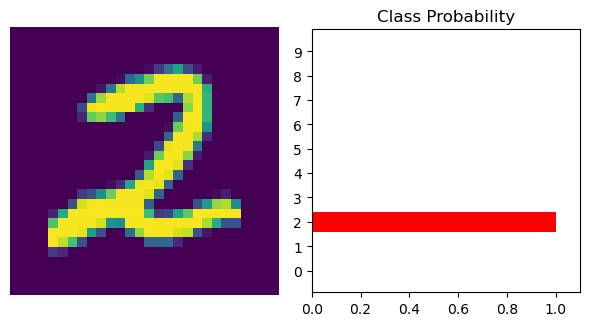

torch.Size([1, 1, 28, 28])


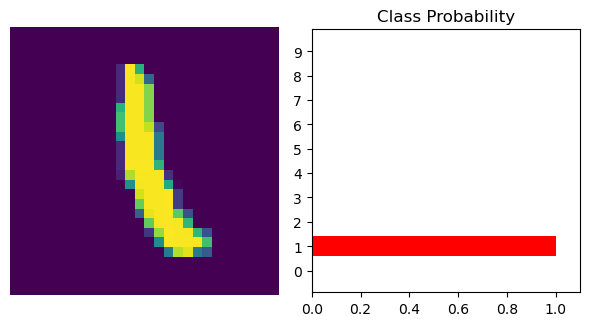

torch.Size([1, 1, 28, 28])


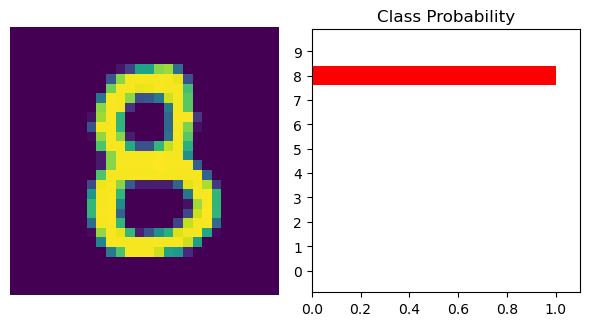

torch.Size([1, 1, 28, 28])


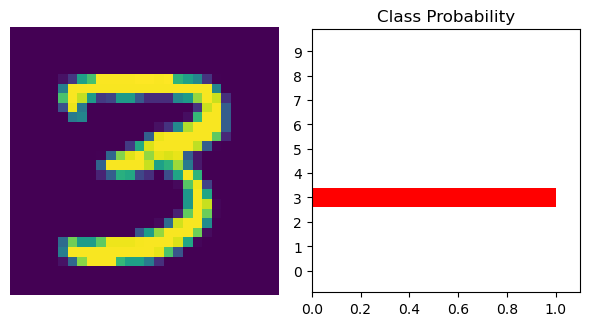

torch.Size([1, 1, 28, 28])


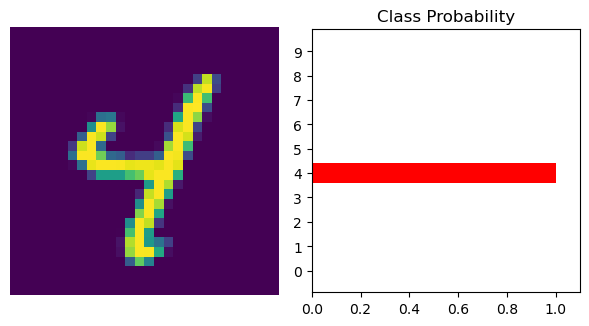

torch.Size([1, 1, 28, 28])


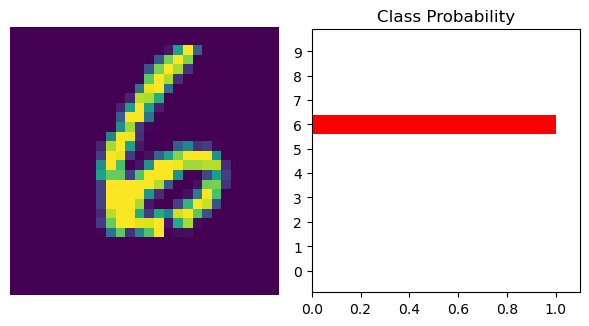

torch.Size([1, 1, 28, 28])


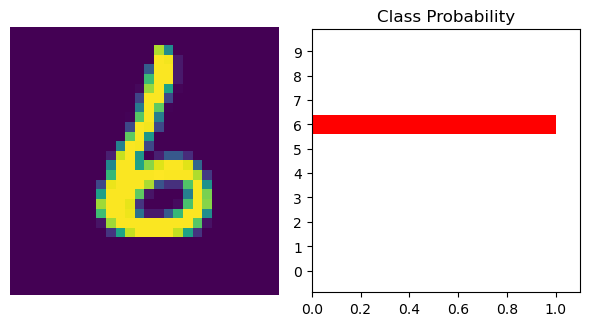

torch.Size([1, 1, 28, 28])


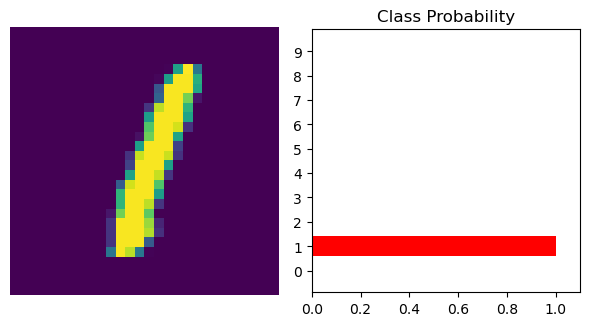

torch.Size([1, 1, 28, 28])


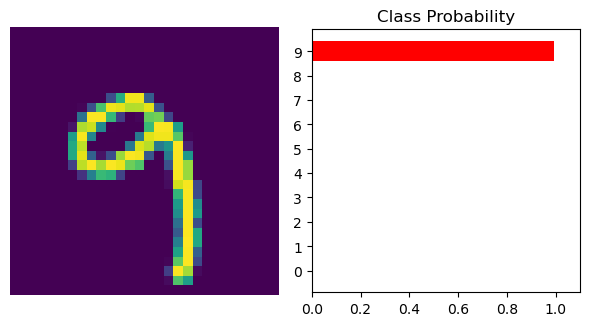

torch.Size([1, 1, 28, 28])


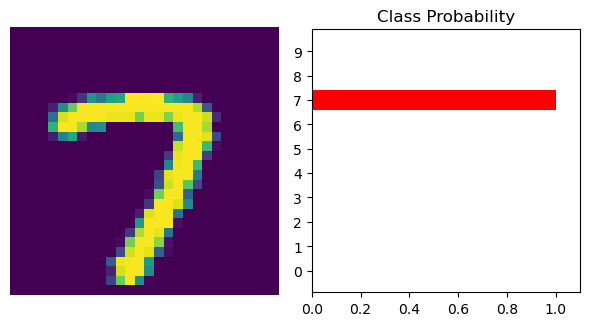

torch.Size([1, 1, 28, 28])


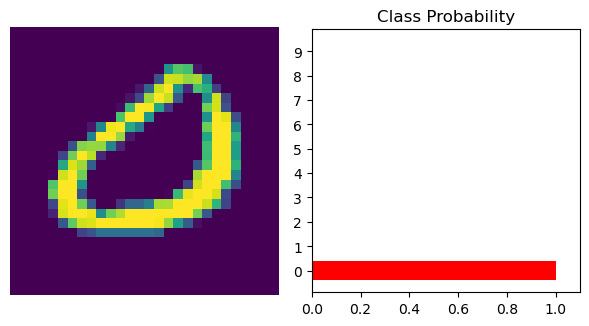

torch.Size([1, 1, 28, 28])


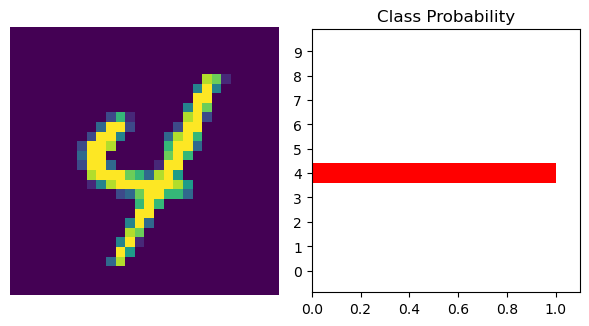

torch.Size([1, 1, 28, 28])


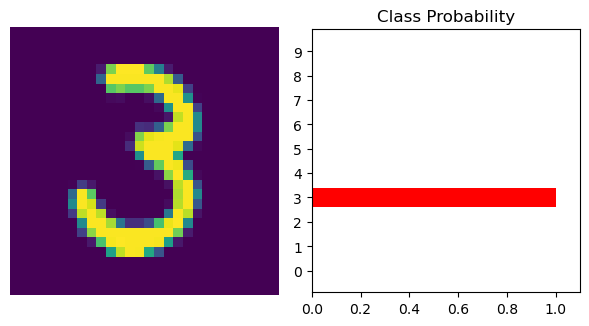

In [15]:
for i in range(1,15):
    img = images[i]
    img = img.to(device)
    img = img.view(-1, 1, 28, 28)
    print(img.shape)

    # Use pretrained weights to make some prediction
    # Have to turn off the gradient
    with torch.no_grad():
        logits = model.forward(img)
    probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()


    fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
    ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities, color='r' )
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()


# Assignment: Improving the MNIST Classifier

## Question 1: Data Augmentation  
Modify the given convolutional neural network to include at least one data augmentation technique. You can apply transformations such as rotation, magnification, shearing, or any other augmentation method discussed in the lecture slides.

Once you have implemented the augmentation, retrain the model and compare its performance with the original. Answer the following:  
- What augmentation technique(s) did you apply?  
- How did the augmentation affect the model's accuracy and generalisation?  
- Why do you think this augmentation was beneficial (or not)?  

## Question 2: Modifying the Model Architecture  
Experiment with the architecture of the convolutional neural network. Modify at least two of the following:  
- The number of layers  
- The number of filters per layer  
- The kernel size  
- The activation functions  

After making your modifications, retrain the model and compare its performance with the original. Answer the following:  
- What specific changes did you make?  
- How did the changes impact accuracy and training time?  
- Why do you think these modifications improved or degraded the model's performance?  
